# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [1]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [2]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS_Analysis/VBS23-Post-Hoc-Analysis/src/python/notebooks/../common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/media/Code/Jupyter/notebook/VBS/VBS Analysis Paper/VBS23_KIS

(784, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [3]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["QT"] = "Other"
dataset.loc[dataset.is_joint_embedding_text_query, "QT"] = "Text"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["category"]=="TEXT","QueryLen"] = dataset.loc[dataset["category"]=="TEXT","value"].str.len()
dataset.loc[dataset["category"]=="TEXT","QueryWords"] = dataset.loc[dataset["category"]=="TEXT","value"].str.split().str.len()

dataset.head()

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,Text,49,8
112,112,112,vbs23-kis-v-m2,vibro,1,1673271280000,29638,45672.0,1.0,4.0,...,video Molok,{},NaN,False,False,None,visual,Other,-1,-1
113,113,113,vbs23-kis-v-m3,vibro,1,1673271639000,15343,24472.0,3.0,6.0,...,black and white dotted snake hiding,{},NaN,False,True,"[-115, -128, 125, 123, 121, -122, 125, -127, -118, 125, 120, 116, 125, 125, 125, 118, 122, -116, -128, 125, 125, -119, -117, -126, 118, 126, -128, -121, -121, -122, 122, -116, -122, 125, -118, 126, 124, 126, 126, 120, 115, -125, -122, -122, 118, -125, 124, 115, -118, -123, 124, 127, 125, 126, -123, -127, 123, 127, -124, -127, 118, -123, 122, -126, 121, 126, 120, -126, 124, -128, -126, -126, 124, 125, 121, 122, -127, -127, 126, 119, -128, -127, 126, 118, -122, -121, 127, 122, -124, 124, -125, 109, 113, 118, -124, 119, 115, -118, 125, 124, ...]",visual,Text,36,6
114,114,114,vbs23-kis-v-m4,vibro,1,1673272419000,45815,211429.0,505.0,505.0,...,fishes over corals,{},NaN,False,True,"[124, 126, 121, 121, 121, -119, -127, -128, 118, -125, 127, 124, -128, 124, -124, 126, -127, -123, -124, 126, 124, -125, -127, -127, -124, -128, 126, 123, 126, -125, 116, -119, 124, -125, -127, 121, 117, -117, -125, -127, -127, -128, -124, -123, -126, -126, 126, 116, 127, 121, 122, 124, -123, -123, -127, 119, -117, 124, -127, -127, 125, -115, 125, -126, 121, -125, 127, -124, -127, 127, 127, -127, 120, -128, 118, -118, -126, 126, 124, 122, -118, 125, -126, 118, -125, -128, 126, 122, -122, 124, 127, 121, -119, 120, -121, -125, -123, 127, -125, 127, ...]",visual,Text,18,3
115,115,115,vbs23-kis-v-m4,vibro,1,1673272427000,53815,211429.0,393.0,393.0,...,fishes over corals with blue water,{},NaN,False,True,"[121, 126, 119, 122, 123, -120, 127, -128, 115, -126, -127, 124, -127, 121, -120, -127, 124, -121, -128, -127, -125, -121, -125, -128, -122, 123, 124, 124, 121, -127, 117, -123, 125, -124, -126, 123, 115, -119, -122, -126, -127, 127, -128, -121, -125, 126, -128, 121, -127, 123, 124, 127, -123, -127, -124, 117, -116, 124, -127, 125, 126, -115, 121, -125, 120, -122, -128, -124, -127, 125, 124, 125, 122, -126, 116, -115, 126, 118, 122, 121, -119, 123, -124, 116, 127, -125, 125, 122, -123, 121, -126, 122, -117, 113, -121, -125, -116, -127, -120, 127, ...]",visual,Text,34,6


# Work with text embeddings

In [4]:
dataset.columns

Index(['level_0', 'index', 'task', 'team', 'user', 'timestamp',
       'elapsed_since_task_start_ms', 'correct_submission_time_ms',
       'rank_video', 'rank_shot_margin_0', 'rank_shot_margin_5', 'max_rank',
       'category', 'type', 'value', 'additionals',
       'is_user_with_correct_submission', 'is_temporal_query',
       'is_joint_embedding_text_query', 'joint_text_embedding', 'task_type',
       'QT', 'QueryLen', 'QueryWords'],
      dtype='object')

In [5]:
dataset

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,value,additionals,is_user_with_correct_submission,is_temporal_query,is_joint_embedding_text_query,joint_text_embedding,task_type,QT,QueryLen,QueryWords
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,Man in pink closest standing a basketball stadium,{},NaN,False,True,"[123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]",visual,Text,49,8
112,112,112,vbs23-kis-v-m2,vibro,1,1673271280000,29638,45672.0,1.0,4.0,...,video Molok,{},NaN,False,False,None,visual,Other,-1,-1
113,113,113,vbs23-kis-v-m3,vibro,1,1673271639000,15343,24472.0,3.0,6.0,...,black and white dotted snake hiding,{},NaN,False,True,"[-115, -128, 125, 123, 121, -122, 125, -127, -118, 125, 120, 116, 125, 125, 125, 118, 122, -116, -128, 125, 125, -119, -117, -126, 118, 126, -128, -121, -121, -122, 122, -116, -122, 125, -118, 126, 124, 126, 126, 120, 115, -125, -122, -122, 118, -125, 124, 115, -118, -123, 124, 127, 125, 126, -123, -127, 123, 127, -124, -127, 118, -123, 122, -126, 121, 126, 120, -126, 124, -128, -126, -126, 124, 125, 121, 122, -127, -127, 126, 119, -128, -127, 126, 118, -122, -121, 127, 122, -124, 124, -125, 109, 113, 118, -124, 119, 115, -118, 125, 124, ...]",visual,Text,36,6
114,114,114,vbs23-kis-v-m4,vibro,1,1673272419000,45815,211429.0,505.0,505.0,...,fishes over corals,{},NaN,False,True,"[124, 126, 121, 121, 121, -119, -127, -128, 118, -125, 127, 124, -128, 124, -124, 126, -127, -123, -124, 126, 124, -125, -127, -127, -124, -128, 126, 123, 126, -125, 116, -119, 124, -125, -127, 121, 117, -117, -125, -127, -127, -128, -124, -123, -126, -126, 126, 116, 127, 121, 122, 124, -123, -123, -127, 119, -117, 124, -127, -127, 125, -115, 125, -126, 121, -125, 127, -124, -127, 127, 127, -127, 120, -128, 118, -118, -126, 126, 124, 122, -118, 125, -126, 118, -125, -128, 126, 122, -122, 124, 127, 121, -119, 120, -121, -125, -123, 127, -125, 127, ...]",visual,Text,18,3
115,115,115,vbs23-kis-v-m4,vibro,1,1673272427000,53815,211429.0,393.0,393.0,...,fishes over corals with blue water,{},NaN,False,True,"[121, 126, 119, 122, 123, -120, 127, -128, 115, -126, -127, 124, -127, 121, -120, -127, 124, -121, -128, -127, -125, -121, -125, -128, -122, 123, 124, 124, 121, -127, 117, -123, 125, -124, -126, 123, 115, -119, -122, -126, -127, 127, -128, -121, -125, 126, -128, 121, -127, 123, 124, 127, -123, -127, -124, 117, -116, 124, -127, 125, 126, -115, 121, -125, 120, -122, -128, -124, -127, 125, 124, 125, 122, -126, 116, -115, 126, 118, 122, 121, -119, 123, -124, 116, 127, -125, 125, 122, -123, 121, -126, 122, -117, 113, -121, -125, -116, -127, -120, 127, ...]",visual,Text,34,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,507,507,vbs23-kis-v5,CVHunter,1,1673278561140,14899,52222.0,12.0,12.0,...,river with white sand,NaN,1.0,False,True,"[118, -126, -127, 124, 126, 127, 126, 124, -124, -124, 126, 122, 125, -128, -124, 127, 122, -125, -128, 122, 125, -127, 125, 126, -128, 127, -123, -125, -121, 120, 125, -121, -117, 120, -126, -125, 126, -128, 122, -124, -128, -120, -127, -128, -122, 122, -120, 124, -127, 126, 121, 126, 122, 124, 127, 123, -127, -123, 127, -127, 126, -118, 116, -128, 112, -117, -125, 126, -125, -127, -128, 118, 118, -124, 119, -124, 124, -128, 127, 126, -120, 125, 127, 126, -123, 117, -120, -126, 116, -124, 125, -127, 125, 121, 123, -124, 126, -127, 122, 119, ...]",visual,Text,21,4
10

In [23]:
dataset.QT.unique()

array(['Text', 'Other'], dtype=object)

In [7]:
import json
stdf = dataset.loc[dataset.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)

In [8]:
stdf.shape

(601, 768)

In [9]:
embedColnames = ["f_"+str(i) for i in range(stdf.shape[1])]
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dataset.loc[dataset.QT=="Text"].index)

In [10]:
jointDF = pd.concat([dataset.loc[dataset.QT=="Text"], dfEmbeds], axis=1)
jointDF

,level_0,index,task,team,user,timestamp,elapsed_since_task_start_ms,correct_submission_time_ms,rank_video,rank_shot_margin_0,...,f_758,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767
0,0,0,vbs23-kis-v1,vibro,0,1673259650000,36687,43981.0,1.0,1.0,...,125,-124,-125,119,127,-125,116,122,-128,-128
113,113,113,vbs23-kis-v-m3,vibro,1,1673271639000,15343,24472.0,3.0,6.0,...,-125,125,-125,-125,123,-127,-128,-128,-113,126
114,114,114,vbs23-kis-v-m4,vibro,1,1673272419000,45815,211429.0,505.0,505.0,...,126,-124,-125,-128,115,-124,-122,117,121,127
115,115,115,vbs23-kis-v-m4,vibro,1,1673272427000,53815,211429.0,393.0,393.0,...,-128,-121,-126,126,114,-123,-119,118,123,-128
116,116,116,vbs23-kis-v-m4,vibro,1,1673272445000,71815,211429.0,508.0,508.0,...,-127,-124,-126,-125,127,-126,-126,120,119,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,507,507,vbs23-kis-v5,CVHunter,1,1673278561140,14899,52222.0,12.0,12.0,...,-127,125,-127,120,126,123,125,127,121,125
1011,307,307,vbs23-kis-t5,CVHunter,1,1673262845945,19333,105663.0,1056.0,1056.0,...,122,-126,-124,120,117,-128,124,-124,123,-126
1000,296,296,vbs23-kis-t4,CVHunter,0,1673262671653,348898,NaN,142.0,142.0,...,-124,121,125,119,122,-128,-126,-124,121,127
987,283,283,vbs23-kis-t4,CVHunter,0,1673262597224,274469,NaN,148.0,148.0,...,-126,124,-128,121,121,-128,-128,-124,119,-128


In [11]:
jointDF.task.unique()

array(['vbs23-kis-v1', 'vbs23-kis-v-m3', 'vbs23-kis-v-m4',
       'vbs23-kis-v-m5', 'vbs23-kis-v-m2', 'vbs23-kis-t6', 'vbs23-kis-v6',
       'vbs23-kis-v3', 'vbs23-kis-t5', 'vbs23-kis-v2', 'vbs23-kis-t3',
       'vbs23-kis-v5', 'vbs23-kis-v-m7', 'vbs23-kis-t4', 'vbs23-kis-v-m1',
       'vbs23-kis-t1', 'vbs23-kis-t2', 'vbs23-kis-v4', 'vbs23-kis-t7'],
      dtype=object)

In [13]:
from sklearn.metrics import pairwise_distances
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

def ILD(dataset, columns):
    dt = dataset[columns].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt,metric="cosine")
    #remove distances to self
    distMatrix = upper_tri_indexing(distMatrix)
    return (distMatrix,distMatrix.mean())


In [14]:
upper_tri_indexing(np.array([[1,2,3],[4,5,6],[7,8,9]]))

array([2, 3, 6])

### How does query distances differ for individual tasks?

In [15]:
dMats = {}
for t in jointDF.task.unique():    
    distMatrix, meanVal = ILD(jointDF.loc[jointDF["task"]==t],embedColnames)
    dMats[t] = distMatrix.ravel()
    print (t, meanVal)
dMats = pd.Series(dMats)

vbs23-kis-v1 0.7477671062654536
vbs23-kis-v-m3 0.788559162936822
vbs23-kis-v-m4 0.6428540864191427
vbs23-kis-v-m5 0.7264995261341203
vbs23-kis-v-m2 0.6364905691234506
vbs23-kis-t6 0.7424703405271253
vbs23-kis-v6 0.5598593348780049
vbs23-kis-v3 0.6589267922854443
vbs23-kis-t5 0.6742861625914418
vbs23-kis-v2 0.6899383133486652
vbs23-kis-t3 0.48438622183154806
vbs23-kis-v5 0.5940814595213899
vbs23-kis-v-m7 0.6365285675236476
vbs23-kis-t4 0.588271540390564
vbs23-kis-v-m1 0.6371778778661308
vbs23-kis-t1 0.5559883253414937
vbs23-kis-t2 0.7119440472975338
vbs23-kis-v4 0.6528187686659883
vbs23-kis-t7 0.6284913147005623


In [16]:
textTasks = [i for i in jointDF.task.unique() if "kis-t" in i]
visualTasks = [i for i in jointDF.task.unique() if (("kis-v-" not in i)&("kis-v" in i))]
marineTasks = [i for i in jointDF.task.unique() if "kis-v-" in i]

### Textual tasks have smaller between-query distances than both visual ones
- also marine tasks has slightly smaller distances than V3C1 visual ones

0.5715605922124235
0.6661421501169522
0.6511813730172652
Ttest_indResult(statistic=-25.729548134511685, pvalue=3.5691723560033423e-141)
Ttest_indResult(statistic=-17.18883273972164, pvalue=5.133851336775138e-65)
Ttest_indResult(statistic=-3.0153602884055766, pvalue=0.002578461202042154)


<AxesSubplot: xlabel='type', ylabel='v'>

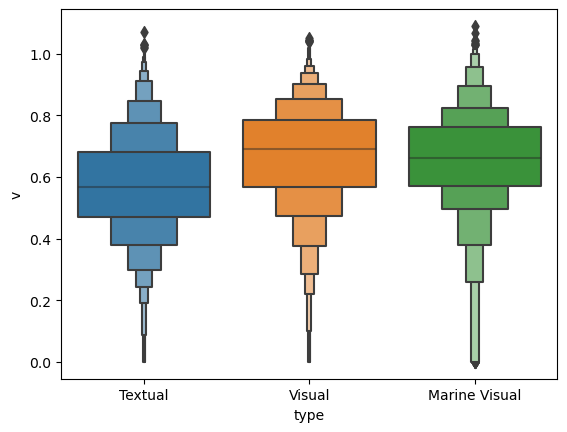

In [19]:
from scipy.stats import ttest_ind

print(np.concatenate(dMats[textTasks].values).mean())
print(np.concatenate(dMats[visualTasks].values).mean())
print(np.concatenate(dMats[marineTasks].values).mean())
print(ttest_ind(np.concatenate(dMats[textTasks].values),np.concatenate(dMats[visualTasks].values)))
print(ttest_ind(np.concatenate(dMats[textTasks].values),np.concatenate(dMats[marineTasks].values)))
print(ttest_ind(np.concatenate(dMats[marineTasks].values),np.concatenate(dMats[visualTasks].values)))

txt = pd.DataFrame({"v": np.concatenate(dMats[textTasks].values)})
txt["type"]="Textual"
vis = pd.DataFrame({"v": np.concatenate(dMats[visualTasks].values)})
vis["type"]="Visual"
mar = pd.DataFrame({"v": np.concatenate(dMats[marineTasks].values)})
mar["type"]="Marine Visual"
dfPlot = pd.concat([txt,vis,mar])

sns.boxenplot(y=dfPlot["v"],x=dfPlot["type"])

## Team-wise differences

In [20]:
dMats = {}
for t in jointDF.task.unique():
    for tm in jointDF.team.unique():
        distMatrix, meanVal = ILD(jointDF.loc[((jointDF["task"]==t)&(jointDF["team"]==tm))],embedColnames)
        dMats[(t,tm)] = distMatrix.ravel()
        print (t, tm, meanVal)
dMats = pd.Series(dMats)

vbs23-kis-v1 vibro 0.6243898402042198
vbs23-kis-v1 VISIONE 0.8827869155202819
vbs23-kis-v1 vitrivr-VR 0.546614305360363
vbs23-kis-v1 Verge 0.7392126668860525
vbs23-kis-v1 CVHunter 0.6508291445043268
vbs23-kis-v-m3 vibro 0.7777926444499748
vbs23-kis-v-m3 VISIONE 0.7840317086676769
vbs23-kis-v-m3 vitrivr-VR 0.7658810761531814
vbs23-kis-v-m3 Verge nan
vbs23-kis-v-m3 CVHunter 0.7337742502703684
vbs23-kis-v-m4 vibro 0.4577823538074015
vbs23-kis-v-m4 VISIONE 0.6030152727414229
vbs23-kis-v-m4 vitrivr-VR 0.4788592655051954
vbs23-kis-v-m4 Verge 0
vbs23-kis-v-m4 CVHunter 0.5372833133981157
vbs23-kis-v-m5 vibro 0.5508232122376123
vbs23-kis-v-m5 VISIONE 0.7056982522710418
vbs23-kis-v-m5 vitrivr-VR 0.48038566558546286
vbs23-kis-v-m5 Verge nan
vbs23-kis-v-m5 CVHunter 0.699259703655281
vbs23-kis-v-m2 vibro 0.5327362243977989
vbs23-kis-v-m2 VISIONE 0.5805972939146946
vbs23-kis-v-m2 vitrivr-VR 0.5659605255194815
vbs23-kis-v-m2 Verge 0.5987260318857961
vbs23-kis-v-m2 CVHunter 0.5668296953681099
vbs23-ki

/tmp/ipykernel_74400/230752218.py:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
/home/administrator/anaconda3/envs/vbs2023/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_74400/230752218.py:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
/home/administrator/anaconda3/envs/vbs2023/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_74400/230752218.py:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
/home/administrator/anaconda3/envs/vbs2023/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_74400/230752218.py:14: RuntimeWarning: Mean of em

In [21]:
for tm in jointDF.team.unique():
    keys = list(np.broadcast(jointDF.task.unique(),tm))
    print(tm, np.concatenate(dMats[keys].values).mean())

vibro 0.49269313518869223
VISIONE 0.46711998649699965
vitrivr-VR 0.5987798117888103
Verge 0.6387530611128063
CVHunter 0.5561263176089749


### Both vibro and VISIONE had more consistent per-task queries than CVHunter
- comparison with other teams omitted due to missing data

In [175]:
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"vibro"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"CVHunter"))].values)))
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"VISIONE"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"CVHunter"))].values)))
print(ttest_ind(np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"vibro"))].values),np.concatenate(dMats[list(np.broadcast(jointDF.task.unique(),"VISIONE"))].values)))

Ttest_indResult(statistic=-4.995375977987914, pvalue=6.813767259702913e-07)
Ttest_indResult(statistic=-10.12082861576172, pvalue=1.6579739468135622e-23)
Ttest_indResult(statistic=1.9297088510459783, pvalue=0.05383385750645739)


## Comparison of both users per team and task

In [176]:
jointDF.groupby(["team","user"]).count()["task"]

team        user
CVHunter    0        76
            1        71
VISIONE     0        50
            1       117
Verge       0       139
vibro       0        38
            1        49
vitrivr-VR  0        38
            1        23
Name: task, dtype: int64

- removing verge as no distinction between users is available
- several times, vitrivr-VR does not have any records from one of the users (candidate for removal)

In [177]:
jointDFNoVerge = jointDF.loc[jointDF.team != "Verge"]
jointDF.shape,jointDFNoVerge.shape

((601, 800), (462, 800))

In [187]:
def ILD_pair(dataset1, dataset2, columns):
    dt1 = dataset1[columns].values
    dt2 = dataset2[columns].values
    if (len(dt1)==0)|(len(dt2)==0):
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt1,dt2,metric="cosine")
    return (distMatrix.flatten(),distMatrix.mean())

In [188]:
dMats = {}
for t in jointDFNoVerge.task.unique():
    for tm in jointDFNoVerge.team.unique():
        dt1 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==0))]
        dt2 = jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==1))] 
        
        distMatrix, meanVal = ILD_pair(dt1, dt2, embedColnames)
        dMats[(t,tm)] = distMatrix.ravel()
        print (t, tm, meanVal)
dMats = pd.Series(dMats)

vbs23-kis-v1 vibro 0.7299225463886151
vbs23-kis-v1 VISIONE 0.882786915520282
vbs23-kis-v1 vitrivr-VR 0.6870587435670762
vbs23-kis-v1 CVHunter 0.7302483775459264
vbs23-kis-v-m3 vibro 0.7777926444499749
vbs23-kis-v-m3 VISIONE 0.7840317086676768
vbs23-kis-v-m3 vitrivr-VR 0.8347883196201766
vbs23-kis-v-m3 CVHunter 0.8398110186666613
vbs23-kis-v-m4 vibro 0.6023711039587775
vbs23-kis-v-m4 VISIONE 0.6942907617717886
vbs23-kis-v-m4 vitrivr-VR 0.6899648910542605
vbs23-kis-v-m4 CVHunter 0.6315031924718134
vbs23-kis-v-m5 vibro 0.6363430175800942
vbs23-kis-v-m5 VISIONE 0.8181227141720234
vbs23-kis-v-m5 vitrivr-VR 0.468125971547914
vbs23-kis-v-m5 CVHunter 0.699259703655281
vbs23-kis-v-m2 vibro 0.5327362243977993
vbs23-kis-v-m2 VISIONE 0.7223737200249091
vbs23-kis-v-m2 vitrivr-VR 0.6302394695116016
vbs23-kis-v-m2 CVHunter 0.5791745811294862
vbs23-kis-t6 vibro 0.5525175810728975
vbs23-kis-t6 VISIONE 0.7367491595291309
vbs23-kis-t6 vitrivr-VR 0
vbs23-kis-t6 CVHunter 0.7329211147068825
vbs23-kis-v6 vib

In [189]:
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    print(tm, np.concatenate(dMats[keys].values).mean())

vibro 0.5775548092377715
VISIONE 0.5447035770063968
vitrivr-VR 0.6723673846326323
CVHunter 0.6337494029541245


- not so much different from the results of the overall distances (just a bit higher values)

In [191]:
dMats2 = {}
for t in jointDFNoVerge.task.unique():
    for tm in jointDFNoVerge.team.unique():
        for u in jointDFNoVerge.user.unique():
            distMatrix, meanVal = ILD(jointDFNoVerge.loc[((jointDFNoVerge["task"]==t)&(jointDFNoVerge["team"]==tm)&(jointDFNoVerge["user"]==u))],embedColnames)
            dMats2[(t,tm,u)] = distMatrix.ravel()
            print (t, tm,u, meanVal)
dMats2 = pd.Series(dMats2)

<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distM

vbs23-kis-v1 vibro 0 nan
vbs23-kis-v1 vibro 1 0.5188571340198246
vbs23-kis-v1 VISIONE 0 nan
vbs23-kis-v1 VISIONE 1 nan
vbs23-kis-v1 vitrivr-VR 0 0.45298467988922103
vbs23-kis-v1 vitrivr-VR 1 nan
vbs23-kis-v1 CVHunter 0 0.605724103051525
vbs23-kis-v1 CVHunter 1 0.5086623637163303
vbs23-kis-v-m3 vibro 0 nan
vbs23-kis-v-m3 vibro 1 nan
vbs23-kis-v-m3 VISIONE 0 nan
vbs23-kis-v-m3 VISIONE 1 nan
vbs23-kis-v-m3 vitrivr-VR 0 0.628066589219191
vbs23-kis-v-m3 vitrivr-VR 1 nan
vbs23-kis-v-m3 CVHunter 0 0.521700713477782
vbs23-kis-v-m3 CVHunter 1 nan
vbs23-kis-v-m4 vibro 0 0.3386861356436494
vbs23-kis-v-m4 vibro 1 0.33609672253367
vbs23-kis-v-m4 VISIONE 0 0.282346717176504
vbs23-kis-v-m4 VISIONE 1 0.6495132629413481
vbs23-kis-v-m4 vitrivr-VR 0 0.23664828652304795
vbs23-kis-v-m4 vitrivr-VR 1 0.243280135005558
vbs23-kis-v-m4 CVHunter 0 0.3099771464061387
vbs23-kis-v-m4 CVHunter 1 0.3877099640952998
vbs23-kis-v-m5 vibro 0 0.3797836015526491
vbs23-kis-v-m5 vibro 1 nan
vbs23-kis-v-m5 VISIONE 0 0.4743827

C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-184-3887b7fc3f9f>:14: RuntimeWarning: Mean of empty slice.
  return (distMatrix,distMatrix.mean())
C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarn

- quite a few NaNs due to having only a single query per user

In [211]:
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    users = [0]*len(keys)+[1]*len(keys)
    keys = [(keys[i%len(keys)][0],keys[i%len(keys)][1],val) for i,val in enumerate(users)]
    print(tm, np.concatenate(dMats2[keys].values).mean())

vibro 0.4022114827257665
VISIONE 0.42052737879026175
vitrivr-VR 0.5099672238738527
CVHunter 0.46619204399671793


## Much smaller differences in within-user query distance as compared to between users (in the same team)

In [212]:
for tm in jointDFNoVerge.team.unique():
    keys = list(np.broadcast(jointDFNoVerge.task.unique(),tm))
    keys1 = keys
    users = [0]*len(keys)+[1]*len(keys)
    keys = [(keys[i%len(keys)][0],keys[i%len(keys)][1],val) for i,val in enumerate(users)]
    
    print(tm,ttest_ind(np.concatenate(dMats[keys1].values),np.concatenate(dMats2[keys].values)))

vibro Ttest_indResult(statistic=7.421205730914491, pvalue=1.124815818468862e-12)
VISIONE Ttest_indResult(statistic=10.606143669873463, pvalue=3.7269398596620828e-25)
vitrivr-VR Ttest_indResult(statistic=4.81131998936591, pvalue=4.2062037710805425e-06)
CVHunter Ttest_indResult(statistic=15.437962806255932, pvalue=2.903489579098286e-47)


# Differences in sequences of query reformulations
- only users & tasks, where at least **4** text queries were made

In [290]:
dt = sortedData.loc[((sortedData.QueryRank <= 4)&(sortedData.MaxQueryRank >= 4))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]
dt.columns,dt.shape

(Index(['level_0', 'index', 'task', 'team', 'user', 'timestamp',
        'elapsed_since_task_start_ms', 'correct_submission_time_ms',
        'rank_video', 'rank_shot_margin_0', 'rank_shot_margin_5', 'max_rank',
        'category', 'type', 'value', 'additionals',
        'is_user_with_correct_submission', 'is_temporal_query',
        'is_joint_embedding_text_query', 'joint_text_embedding', 'task_type',
        'QT', 'QueryLen', 'QueryWords', 'rankCat', 'QueryRank', 'MaxQueryRank',
        'DiffFromMaxQueryRank', 'RankForViz'],
       dtype='object'),
 (184, 29))

In [291]:
jointDF[f]

0       123
113    -115
114     124
115     121
116     123
       ... 
1211    118
1011    125
1000    115
987     112
978     124
Name: f_0, Length: 601, dtype: int8

In [292]:
stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(184, 797)

In [293]:
def ILD_noRemove(dataset, columns):
    dt = dataset[columns].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = pairwise_distances(dt,metric="cosine")
    return (distMatrix,distMatrix.mean())


In [294]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.30275063526445845
vbs23-kis-t1 CVHunter 1 0.21095714138323995
vbs23-kis-t1 vitrivr-VR 0 0.3908456840645556
vbs23-kis-t1 vitrivr-VR 1 0.5017352410029574
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.257184990582472
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.3355762795998103
vbs23-kis-t3 CVHunter 1 0.19005352211823046
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.16387107312359503
vbs23-kis-t3 VISIONE 1 0.2337461190265403
vbs23-kis-t3 vibro 0 0.24745527577334522
vbs23-kis-t3 vibro 1 0.33654353600985215
vbs23-kis-t4 CVHunter 0 0.32627500696083156
vbs23-kis-t4 CVHunter 1 0.27875098557214745
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.35

In [295]:
sequentialResultsArray[:,0,:].mean(axis=0)#distances to first query

array([0.        , 0.37078439, 0.48396571, 0.53212385])

In [296]:
#distances to subsequent queries
print(
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean()
)

0.3707843865337633 0.3479969951690431 0.3651399248288837


{'whiskers': [<matplotlib.lines.Line2D at 0x20ee858e580>,
 'caps': [<matplotlib.lines.Line2D at 0x20ee858eca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ee858e1f0>,
 'medians': [<matplotlib.lines.Line2D at 0x20ee8599400>,
 'fliers': [<matplotlib.lines.Line2D at 0x20ee8599790>,
 'means': []}

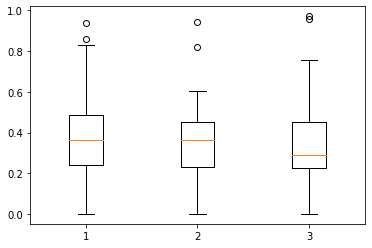

In [303]:
plt.boxplot([sequentialResultsArray[:,0,1],sequentialResultsArray[:,1,2],sequentialResultsArray[:,2,3]])

## While the distance to the initial query rises over time (unsurprisingly), the step size between consecutive queries remain roughly the same and rather small

In [248]:
from Levenshtein import ratio
def LevenshteinNormDist(dataset, txtCol):
    dt = dataset[txtCol].values
    if len(dt)==0:
        return (np.empty(shape=(0, 0)), 0)
    distMatrix = np.zeros((len(dt),len(dt)))
    for i,t1 in enumerate(dt):
        for j,t2 in enumerate(dt):
            distMatrix[i,j] = 1 - ratio(t1,t2)

    return (distMatrix,distMatrix.mean())


In [249]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.13701169487281456
vbs23-kis-t1 CVHunter 1 0.14893449065668954
vbs23-kis-t1 vitrivr-VR 0 0.18593371337298964
vbs23-kis-t1 vitrivr-VR 1 0.29107142857142854
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.09071640798448057
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.39052962065257146
vbs23-kis-t3 CVHunter 1 0.19413782039640162
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.22201951535331116
vbs23-kis-t3 VISIONE 1 0.08051149016316152
vbs23-kis-t3 vibro 0 0.09154050137214392
vbs23-kis-t3 vibro 1 0.3569093337754154
vbs23-kis-t4 CVHunter 0 0.2127426448052832
vbs23-kis-t4 CVHunter 1 0.1501677713081425
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0

In [250]:
sequentialResultsLevensteinArray[:,0,:].mean(axis=0)#distances to first query

array([0.        , 0.23822253, 0.31794311, 0.38222921])

In [251]:
#distances to subsequent queries
print(
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean(),
    sequentialResultsLevensteinArray[:,2,3].mean()
)

0.23822253217099448 0.18370364544595894 0.18766806888970136


In [252]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=1.3916541857306075, pvalue=0.16745718243932117)

## Results of Levenstein distance support those of embeds distance. It seems that subsequent changes are a bit smaller for later reformulations, but no stat sign.

# Differences in sequences of query reformulations
- only users & tasks, where at least **3** text queries were made

In [274]:
dt = sortedData.loc[((sortedData.QueryRank <= 3)&(sortedData.MaxQueryRank >= 3))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(171, 797)

In [275]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.28483638783878723
vbs23-kis-t1 CVHunter 1 0.17352166339955322
vbs23-kis-t1 vitrivr-VR 0 0.25354828740037594
vbs23-kis-t1 vitrivr-VR 1 0.2312007255749904
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.22970694364187974
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.28395178962367745
vbs23-kis-t3 CVHunter 1 0.14963018137644366
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.1757235929840934
vbs23-kis-t3 VISIONE 1 0.24523268536179424
vbs23-kis-t3 vibro 0 0.22287023926274405
vbs23-kis-t3 vibro 1 0.30043918540289316
vbs23-kis-t4 CVHunter 0 0.3041970833922923
vbs23-kis-t4 CVHunter 1 0.22278127057433325
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0

In [276]:
print(sequentialResultsArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean()
)

[0.         0.37521141 0.50212528]
0.3752114051145272 0.3885749788800743


In [280]:
ttest_ind(sequentialResultsArray[:,0,1], sequentialResultsArray[:,1,2])

Ttest_indResult(statistic=-0.33280549807174886, pvalue=0.7399032466617872)

In [277]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.09649196366177498
vbs23-kis-t1 CVHunter 1 0.13221345258343367
vbs23-kis-t1 vitrivr-VR 0 0.12037037037037034
vbs23-kis-t1 vitrivr-VR 1 0.014814814814814812
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.06828035738794504
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.3434485368911598
vbs23-kis-t3 CVHunter 1 0.11622830560028628
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.23994327290664696
vbs23-kis-t3 VISIONE 1 0.07090541958655813
vbs23-kis-t3 vibro 0 0.09756097560975609
vbs23-kis-t3 vibro 1 0.29914494502591693
vbs23-kis-t4 CVHunter 0 0.19703219703219702
vbs23-kis-t4 CVHunter 1 0.09311761006557158
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 

In [263]:
print(sequentialResultsLevensteinArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean()
)

[0.         0.23673469 0.33745884]
0.23673469335393352 0.2188032601324247


In [279]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=0.503428899438058, pvalue=0.6156514552184529)

# Differences in sequences of query reformulations
- only users & tasks, where at least **5** text queries were made

In [265]:
dt = sortedData.loc[((sortedData.QueryRank <= 5)&(sortedData.MaxQueryRank >= 5))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(160, 797)

In [266]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.3204608863792549
vbs23-kis-t1 CVHunter 1 0
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.5532911948594965
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.2846444253950371
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.35245335366070873
vbs23-kis-t3 CVHunter 1 0.20889489450373944
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.14649448012392802
vbs23-kis-t3 VISIONE 1 0.21091126562372564
vbs23-kis-t3 vibro 0 0.3680848524344827
vbs23-kis-t3 vibro 1 0.37073323733946767
vbs23-kis-t4 CVHunter 0 0.36113288259727966
vbs23-kis-t4 CVHunter 1 0.2760300691261661
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.3892132167882514
vbs23-kis-t4 vibro 0

In [267]:
print(sequentialResultsArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean(),
    sequentialResultsArray[:,3,4].mean()
)

[0.         0.36611118 0.49892761 0.53917132 0.57697058]
0.36611118247521957 0.34763253777711167 0.3666472293595896 0.36222809984661386


In [268]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.22027721217206292
vbs23-kis-t1 CVHunter 1 0
vbs23-kis-t1 vitrivr-VR 0 0
vbs23-kis-t1 vitrivr-VR 1 0.3484010960216809
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.13136336364943785
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.4072567917211407
vbs23-kis-t3 CVHunter 1 0.2322698975804111
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.19780540140584535
vbs23-kis-t3 VISIONE 1 0.0775287563576858
vbs23-kis-t3 vibro 0 0.24003734377221797
vbs23-kis-t3 vibro 1 0.38376671831036774
vbs23-kis-t4 CVHunter 0 0.22690151100518882
vbs23-kis-t4 CVHunter 1 0.15994240765081663
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.25866809922898126
vbs23-kis-t4 vibro

In [269]:
print(sequentialResultsLevensteinArray[:,0,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean(),
    sequentialResultsLevensteinArray[:,2,3].mean(),
    sequentialResultsLevensteinArray[:,3,4].mean()
)

[0.         0.23750161 0.33935781 0.40317199 0.46569836]
0.23750161021718114 0.1996924129572446 0.20073452059222216 0.20171359586949283


# Differences in sequences of query reformulations
- only users & tasks, where at least **4** text queries were made
- selecting last 4 queries

In [304]:
dt = sortedData.loc[((sortedData.DiffFromMaxQueryRank >= -3)&(sortedData.MaxQueryRank >= 4))]
#cannot be done for verge as only one user is present
dt = dt.loc[dt.team != "Verge"]

stdf = dt.loc[dt.QT=="Text",'joint_text_embedding'].values
stdf = np.stack(stdf)
dfEmbeds = pd.DataFrame(stdf, columns=embedColnames, index=dt.loc[dt.QT=="Text"].index)
seqDFEmbeds = pd.concat([dt.loc[dt.QT=="Text"], dfEmbeds], axis=1)
seqDFEmbeds.shape

(184, 797)

In [305]:
dMats3 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = ILD_noRemove(dt,embedColnames)
            if len(distMatrix)>0:
                dMats3[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats3 = pd.Series(dMats3)
sequentialResultsArray = np.stack(dMats3.values)

vbs23-kis-t1 CVHunter 0 0.284206300080437
vbs23-kis-t1 CVHunter 1 0.21095714138323995
vbs23-kis-t1 vitrivr-VR 0 0.3908456840645556
vbs23-kis-t1 vitrivr-VR 1 0.574684088732962
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.19768730093793774
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.2181340300070374
vbs23-kis-t3 CVHunter 1 0.14164195557292938
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.17582654247167084
vbs23-kis-t3 VISIONE 1 0.17952915627507915
vbs23-kis-t3 vibro 0 0.38946043200614144
vbs23-kis-t3 vibro 1 0.36220561942721774
vbs23-kis-t4 CVHunter 0 0.33709583870625676
vbs23-kis-t4 CVHunter 1 0.15800771004917322
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0.34

In [312]:
print(sequentialResultsArray[:,2,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsArray[:,0,1].mean(),
    sequentialResultsArray[:,1,2].mean(),
    sequentialResultsArray[:,2,3].mean()
)

[0.40657062 0.31069379 0.         0.32705572]
0.3317558027813991 0.3106937935484755 0.32705572366690105


In [307]:
ttest_ind(sequentialResultsArray[:,0,1], sequentialResultsArray[:,1,2])

Ttest_indResult(statistic=0.43830963354941543, pvalue=0.6622121204123002)

{'whiskers': [<matplotlib.lines.Line2D at 0x20ee8622fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x20ee8631700>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ee8622c10>,
 'medians': [<matplotlib.lines.Line2D at 0x20ee8631e20>,
 'fliers': [<matplotlib.lines.Line2D at 0x20ee863a1f0>,
 'means': []}

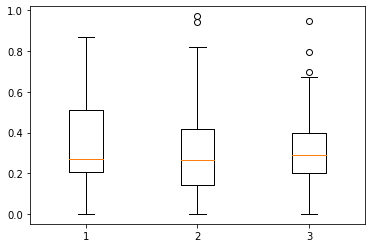

In [311]:
plt.boxplot([sequentialResultsArray[:,0,1],sequentialResultsArray[:,1,2],sequentialResultsArray[:,2,3]])

In [308]:
dMats4 = {}
for t in seqDFEmbeds.task.unique():
    for tm in seqDFEmbeds.team.unique():
        for u in seqDFEmbeds.user.unique():
            dt = seqDFEmbeds.loc[((seqDFEmbeds["task"]==t)&(seqDFEmbeds["team"]==tm)&(seqDFEmbeds["user"]==u))]
            dt = dt.sort_values("QueryRank")
            #print(dt.QueryRank)
            distMatrix, meanVal = LevenshteinNormDist(dt,"value")
            if len(distMatrix)>0:
                dMats4[(t,tm,u)] = distMatrix
            print (t, tm,u, meanVal)
dMats4 = pd.Series(dMats4)
sequentialResultsLevensteinArray = np.stack(dMats4.values)

vbs23-kis-t1 CVHunter 0 0.22900897856166402
vbs23-kis-t1 CVHunter 1 0.14893449065668954
vbs23-kis-t1 vitrivr-VR 0 0.18593371337298964
vbs23-kis-t1 vitrivr-VR 1 0.36933238629274157
vbs23-kis-t1 VISIONE 0 0
vbs23-kis-t1 VISIONE 1 0
vbs23-kis-t1 vibro 0 0
vbs23-kis-t1 vibro 1 0
vbs23-kis-t2 CVHunter 0 0
vbs23-kis-t2 CVHunter 1 0
vbs23-kis-t2 vitrivr-VR 0 0
vbs23-kis-t2 vitrivr-VR 1 0
vbs23-kis-t2 VISIONE 0 0
vbs23-kis-t2 VISIONE 1 0.12250506270890912
vbs23-kis-t2 vibro 0 0
vbs23-kis-t2 vibro 1 0
vbs23-kis-t3 CVHunter 0 0.15604220462796983
vbs23-kis-t3 CVHunter 1 0.0733593115619966
vbs23-kis-t3 vitrivr-VR 0 0
vbs23-kis-t3 vitrivr-VR 1 0
vbs23-kis-t3 VISIONE 0 0.08649333775636714
vbs23-kis-t3 VISIONE 1 0.11456705434613673
vbs23-kis-t3 vibro 0 0.26672105685557823
vbs23-kis-t3 vibro 1 0.3904444905987283
vbs23-kis-t4 CVHunter 0 0.1452827912256306
vbs23-kis-t4 CVHunter 1 0.05845408636694234
vbs23-kis-t4 vitrivr-VR 0 0
vbs23-kis-t4 vitrivr-VR 1 0
vbs23-kis-t4 VISIONE 0 0
vbs23-kis-t4 VISIONE 1 0

In [309]:
print(sequentialResultsLevensteinArray[:,2,:].mean(axis=0)) #distances to first query

print(#distances to subsequent queries
    sequentialResultsLevensteinArray[:,0,1].mean(),
    sequentialResultsLevensteinArray[:,1,2].mean()
)

[0.23209252 0.15453348 0.         0.16372377]
0.18138629828026548 0.15453348434946446


In [310]:
ttest_ind(sequentialResultsLevensteinArray[:,0,1], sequentialResultsLevensteinArray[:,1,2])

Ttest_indResult(statistic=0.7395364345147194, pvalue=0.461505934547612)